<div dir='rtl'>
<h1>پروژه نهم علوم اعصاب محاسباتی</h1>
<br/>
- در فازهای قبل، پارامتر‌های فیلتر‌ها و رمزنگاری‌ها به تفصیل مورد بحث قرار گرفته‌اند. بنابراین در این فاز فقط و به تفصیل به برسی پارامتر‌های لایه‌ی کانولوشن و پولینگ می‌پردازیم.
<br/>
- کد‌ها فقط در ابتدای گزارش زیاد هستند (بخش برپایی آزمایش)
<br/>
- همانطور که خواسته شده بود، توابع کانولوشن و پولینگ با امکان تغییر همه‌ی پارامتر‌ها (از جمله استراید، پدینگ و حتی تابع جامع‌ساز پولینگ) پیاده‌سازی شده و در utils قرار گرفته‌اند. اما با هدف آنکه ساختار کد با ساختار فریم‌ورک پایتورچ سازگار باشد و از دیگر فیلتر‌های آن نیز بتواند استفاده کند، در سیستم کد از این ماژول‌ها استفاده می‌شود. جایگذاری تابع کانولوشن در شبکه‌ی پیاده شده در فاز قبل ارائه شد و در پایان گزارش این فاز نیز، درستی عملکرد توابع پیاده سازی شده نشان داده می‌شود. بنابراین، با برآورده سازی تمام انتظارات طراحان، به حفظ ساختار کد پرداختم.
</div>

<div dir='rtl'>
<h2>0. فهرست مطالب</h2>
<ol>
    <li><a href="#1">برپایی آزمایش</a></li>
    <li><a href="#2">اثر kernel_size لایه‌ی convolution</a></li>
    <li><a href="#3">اثر stride لایه‌ی convolution</a></li>
    <li><a href="#4">اثر padding لایه‌ی convolution</a></li>
        <ol>
        <li><a href="#4A">size</a></li>
        <li><a href="#4B">padding_mode</a></li>
        </ol>
    <li><a href="#5">اثر kernel_size لایه‌ی pooling</a></li>
    <li><a href="#6">اثر stride لایه‌ی pooling</a></li>
    <li><a href="#7">اثر padding لایه‌ی pooling</a></li>
    <li><a href="#8">تفاوت max pooing و avg pooling</a></li>
    <li><a href="#9">تفاوت نتایج برای روش‌های رمزنگاری Poisson و Time2FirstSpike</a></li>
    <li><a href="#10">بررسی توابع convolution و pooling دستی پیاده سازی شده</a></li>
</ol>
</div>

<a id='1'></a>
<div dir='rtl'>
<h2>1. برپایی آزمایش</h2>
</div>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import torch
pi = torch.acos(torch.zeros(1)).item() * 2
path1 = "image1.jpg"

<div dir='rtl'>
در این آزمایش، عکس زیر را از کدگذار مشخصی عبور می‌دهیم و خروجی را از لایه‌ی کانولوشن و سپس پولینگ می‌گذرانیم. خروجی هر لایه را رمزگشایی کرده و تصویر حاصل را رسم می‌کنیم. توجه کنید که بجز در بند نهم، از رمزنگار پواسون استفاده می‌کنیم. همچنین بجز در بند هشتم، از max pooling استفاده.
</div>

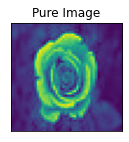

In [3]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter
from PIL import Image
import numpy as np

plt.figure(figsize=(2,2))
p = Plotter([['im1']])
im1 = np.array(Image.open(path1).convert('L'))
gr_im1= Image.fromarray(im1)
p.imshow('im1', gr_im1, title="Pure Image")
p.show()
im1 = torch.from_numpy(im1)

<div dir='rtl'>
در تمام آزمایش‌ها، برای لایه‌ی کانولوشن، از کرنل gabor با اطلاعات زیر استفاده خواهیم کرد:
</div>

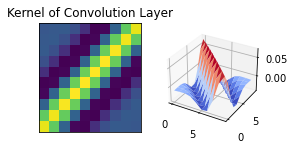

In [3]:
from cnsproject.network.kernels import gabor_kernel
from matplotlib import cm

def kernel(kernel_size):
    return gabor_kernel(
        kernel_size=kernel_size,
        wavelength=6,
        std=2,
        aspect_ratio=.1,
        orientation=torch.tensor(pi/4),
    )

plt.figure(figsize=(4,2))
p = Plotter([['kernel','kernel3D']])
p.imshow('kernel', kernel(10), title="Kernel of Convolution Layer")
p.surface_3d('kernel3D', data={'z': kernel(10)}, cmap=cm.coolwarm)
p.show()

<div dir='rtl'>
در آزمایش‌های مربوط به کانولوشن از پولینگ و در آزمایش‌های پولینگ از کانولوشن زیر استفاده خواهیم کرد. همچنین دقت کنید در تمام آزمایش‌ها، هر لایه‌ی کانولوشن یا پولینگ، یک transformer از نوع نرمالایزر با مقادیر 0.5 خواهد داشت.
</div>

In [4]:
from torchvision import transforms
from cnsproject.network.filters import Conv2dFilter,CoreCentricFilter

norm = transforms.Normalize(.5,.5)
default_conv = Conv2dFilter(kernel=kernel(7), stride=2, padding=3, transform=norm)
default_pooling = CoreCentricFilter(core=torch.nn.MaxPool2d(kernel_size=4, stride=2), transform=norm)

<div dir='rtl'>
برای پرهیز از تکرار نوشتن، تابع شبیه‌سازی لازم برای این تمرین تعریف شده است. تمام پارامتر‌ها قابل تغییرند.
</div>

In [16]:
from cnsproject.network.network import Network
from cnsproject.network.network_wrapper import *
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.synapse_sets import LazySynapseSet
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import FilteringDendriteSet2d
from cnsproject.network.encoders import PoissonEncoder
from cnsproject.monitors.monitors import Monitor

time = 20
dt=1
def simulate(p, conv_layer=default_conv, pooling_layer=default_pooling, encoder=PoissonEncoder,
             time=time, name='', postfix='', title=True, axon_scale=500):
    net = Network(dt=1.)
    if encoder is PoissonEncoder:
        net += encoder('encoder', shape=im1.shape, max_input=255)
    else:
        net += encoder('encoder', shape=im1.shape, max_input=255, time=time)
    net += LazySynapseSet('conv') |FROM| (SimpleAxonSet(scale=axon_scale) |OF| net['encoder']) |TO| \
        FilteringDendriteSet2d(filt=conv_layer)
    net += LIFPopulation('conv_output', net[[['conv']]].dendrite.required_population_shape()) \
        |USING| net[[['conv']]].dendrite
    net += LazySynapseSet('pool') |FROM| (SimpleAxonSet(scale=500) |OF| net['conv_output']) |TO| \
        FilteringDendriteSet2d(filt=pooling_layer)
    net += LIFPopulation('pool_output', net[[['pool']]].dendrite.required_population_shape()) \
        |USING| net[[['pool']]].dendrite
    net.reset()

    monitor = Monitor(net, state_calls={
        'encoder_spikes': net['encoder'].spikes,
        'conv_output_spikes': net['conv_output'].spikes,
        'pool_output_spikes': net['pool_output'].spikes,
    }, time=time)
    monitor.reset()
    net.reset()
    net['encoder'].encode(im1)
    monitor.simulate(net.run, reset=False)

    p.monitor = monitor
    p.imshow('im'+postfix, im1, title="Input Image" if title else '', cmap='YlGn', interpolation='nearest',
            y_label=name)
    p.population_activity_raster('encode'+postfix, y='encoder_spikes', alpha=.1, y_label=None, y_vis=False,
                                 title='encoder_spikes' if title else '', x_vis=False)
    p.imshow('encode_im'+postfix, net['encoder'].decode(monitor['encoder_spikes']),
             title='encoded image' if title else '', cmap='YlGn', interpolation='nearest')
    p.population_activity_raster('conv'+postfix, y='conv_output_spikes', y_label=None, y_vis=False,
                                 title='conv_output_spikes' if title else '', x_vis=False)
    conv_im = PoissonEncoder('temp', shape=monitor['conv_output_spikes'][0].shape, max_input=255)\
                 .decode(monitor['conv_output_spikes'])
    p.imshow('conv_im'+postfix, conv_im, title='conv image' if title else '', cmap='YlGn', interpolation='nearest')
    p.population_activity_raster('pool'+postfix, y='pool_output_spikes', y_label=None, y_vis=False, 
                                 title='pool_output_spikes' if title else '', x_vis=False)
    pool_im = PoissonEncoder('temp'+postfix, shape=monitor['pool_output_spikes'][0].shape, max_input=255)\
                 .decode(monitor['pool_output_spikes'])
    p.imshow('pool_im'+postfix, pool_im, title='pool image' if title else '', cmap='YlGn', interpolation='nearest')
    
plot_line = lambda postfix: [x+str(postfix) for x in ['im','encode','encode_im','conv','conv_im','pool','pool_im']]

<a id='2'></a>
<div dir='rtl'>
<h2>2. اثر kernel_size لایه‌ی convolution</h2>
</div>

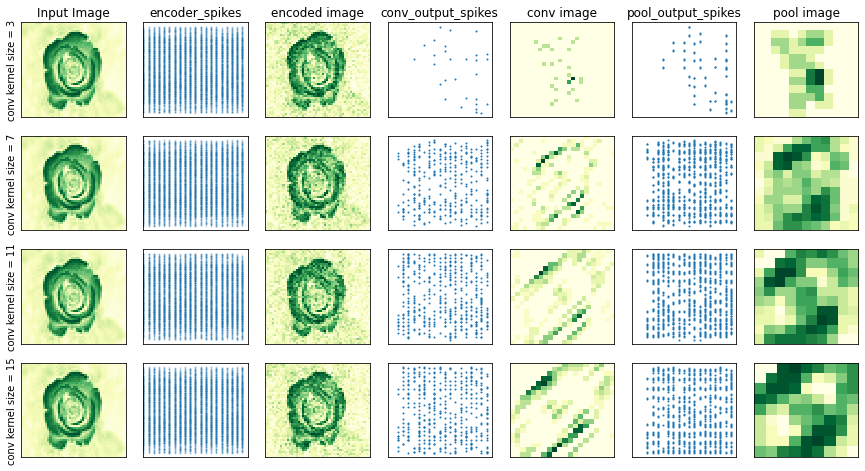

In [6]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(3+4*i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    kernel_size = 3+4*i
    simulate(p, conv_layer=Conv2dFilter(kernel=kernel(kernel_size), stride=2, padding=3, transform=norm),
             postfix=str(kernel_size), title=i==0, name=f'conv kernel size = {kernel_size}')
p.show()

<div dir='rtl'>
    توجه کنید که در آزمایش بالا، stride=2 و padding=3 درنظر گرفته شده است (مقادیر پیشفرض درنظر گرفته شده در ابتدای آزمایش). بررسی این پارامتر‌ها را جلوتر خواهیم دید.
با توجه به نمودار‌های بالا مشاهده می‌کنیم که اندازه بزرگ‌تر کرنل باعث تشخیص خطوط قطورتر شده و این مطابق با انتظارات ماست. دقت کنید که اندازه کرنل پولینگ ثابت است. عملکرد پولینگ، همانطور که انتظار داشتیم، ایجاد انعطاف بوده و رزولوشن را پایین آورده است. با توجه به تصویری که داریم می‌توانیم مشاهده کنیم که خطوط بسیار باریک سهم کمی در تصویر دارند، بنابراین اندازه کرنل بسیار پایین اطلاعات کمتری استخراج می‌کند. همچنین مشاهده می‌کنیم که لایه‌ی کانولوشن با رمزنگاری پواسون رابطه‌ی سازگاری داشته و توانسته اطلاعات تصویر را از تصویر رمز شده به درستی استخراج کند.
</div>

<a id='3'></a>
<div dir='rtl'>
<h2>3. اثر stride لایه‌ی convolution</h2>
</div>

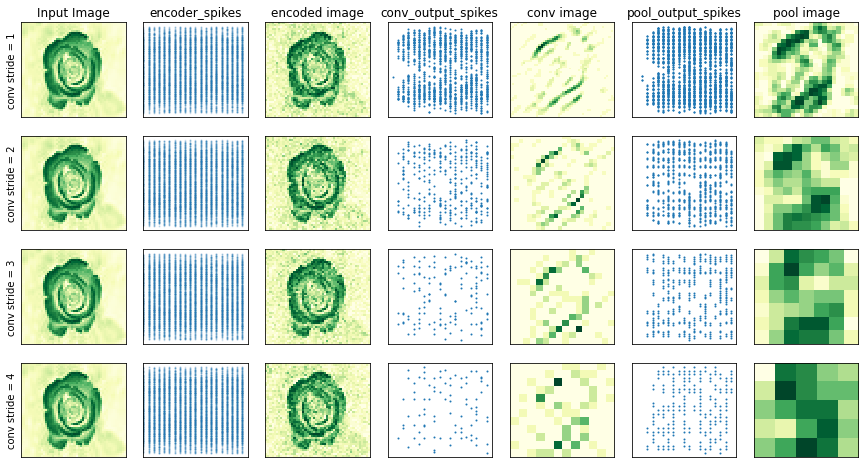

In [7]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    simulate(p, conv_layer=Conv2dFilter(kernel=kernel(7), stride=i+1, padding=3, transform=norm),
             postfix=str(i), title=i==0, name=f'conv stride = {i+1}')
p.show()

<div dir='rtl'>
می‌دانیم که stride به معنای جهش کرنل است و با زیاد شدن آن، رزولوشن پایین آمده و داده‌ی بیشتری از دست می‌رود. همچنین ابعاد تصویر نیز کم شده و در نتیجه در خروجی پولینگ، تعداد پیکسل‌های کمی باقی می‌ماند. با اینحال مشاهده می‌کنیم که stride بسیار کوچک باعث ازدیاد نویز‌ها هم می‌شود.
</div>

<a id='4'></a>
<div dir='rtl'>
<h2>4. اثر padding لایه‌ی convolution</h2>
</div>

<a id='4A'></a>
<div dir='rtl'>
<h3>4A. size</h3>
</div>

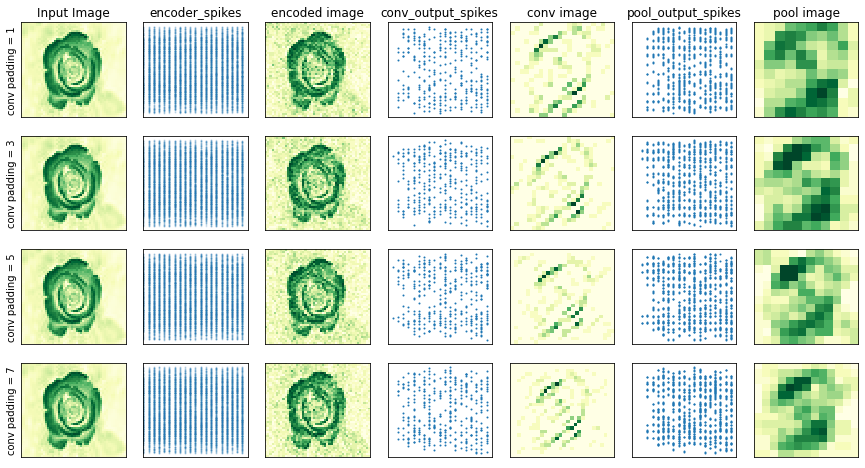

In [8]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    simulate(p, conv_layer=Conv2dFilter(kernel=kernel(7), stride=2, padding=2*i+1, transform=norm),
             postfix=str(i), title=i==0, name=f'conv padding = {2*i+1}')
p.show()

<div dir='rtl'>
می‌دانیم که padding کمک می‌کند تا اطلاعات حاشیه‌ی تصویر را از دست ندهیم. همانطور که در آزمایش بالا مشاهده می‌کنیم، افزایش اندازه‌ی padding مانند zoom out کردن روی تصویر است. در تصویر استفاده شده، حاشیه‌ی تصویر دارای اطلاعات زیادی نیست. به همین دلیل افزایش padding اطلاعات زیادی اضافه نمی‌کند.
</div>

<a id='4B'></a>
<div dir='rtl'>
<h3>4B. padding_mode</h3>
</div>

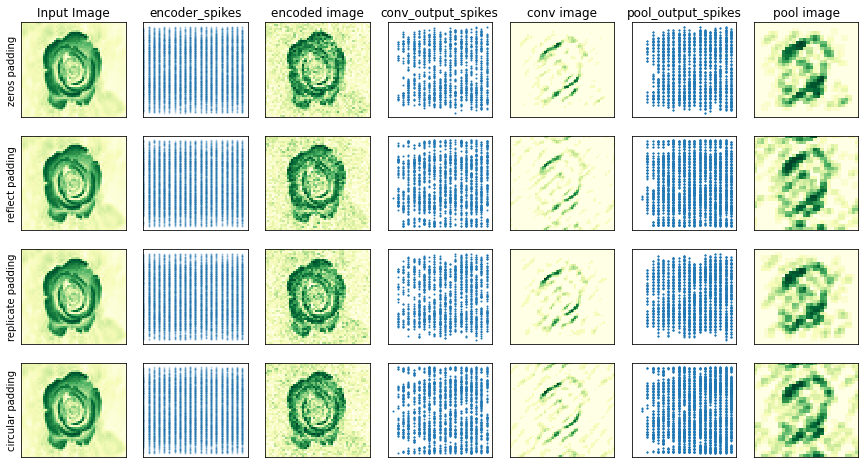

In [9]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    pm = ['zeros', 'reflect', 'replicate', 'circular'][i]
    simulate(p, conv_layer=Conv2dFilter(kernel=kernel(7), padding=10, padding_mode=pm, transform=norm),
             postfix=str(i), title=i==0, name=f'{pm} padding')
p.show()

<div dir='rtl'>
توجه کنید که چون تصویر فوق در حاشیه‌ی خود دارای اطلاعات کمی است، برای نمایش بهتر تفاوت مودهای padding پارامتر‌های stride و padding_size را تغییر دادیم. در تصاویر مشاهده می‌شود که مود صفر باعث ایجاد حاشیه‌ی سفید در تصویر خروجی لایه‌ی کانولوشن می‌شود. این درحالی است که مود‌های رفلیک و دایره‌ای تا حدی از اطلاعات مرکز تصویر برای ایجاد حاشیه برای آن استفاده کردند و الگو‌های شبیه آنچه در مرکز تصویر است، در حاشیه‌ی اضافه شده نیز دیده می‌شود. دیده می‌شود که در مود دایره‌ای، گوشه‌های تصویر نسبت به خروجی مود رفلکت، فعالیت کمتری دارند. مود نیز در این آزمایش عملکری شبیه zero mode دارد چرا که خود تصویر در حاشیه‌ی خود دارای اطلاعاتی نیست و تکثیر آن، تفاوتی با جایگذاری صفر نمیکند. این مود در تصاویری که در حاشیه‌ی خود فعالیت زیادتری دارند خودنمایی بیشتری خواهد داشت.
</div>

<a id='5'></a>
<div dir='rtl'>
<h2>5. اثر kernel_size لایه‌ی pooling</h2>
</div>

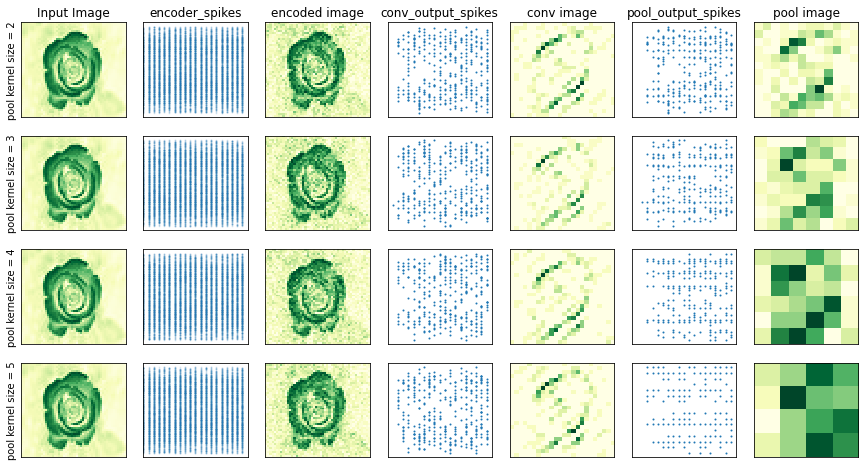

In [10]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    simulate(p, pooling_layer=CoreCentricFilter(core=torch.nn.MaxPool2d(
                kernel_size=i+2,
    ), transform=norm), postfix=str(i), title=i==0, name=f'pool kernel size = {i+2}')
p.show()

<div dir='rtl'>
پیشتر نیز گفتیم که اثر لایه‌ی پولینگ کاهش رزولوشن و افزایش انعطاف مدل است. همانطور که انتظار داشتیم و مشاهده می‌کنیم، با افزایش اندازه‌ی کرنل این لایه، میزان کاهش رزولوشن افزایش می‌یابد و خروجی ابعادی کوچکتر و کیفیتی پایین‌تر دارد. شایان ذکر است که ما فعلا از max_pool استفاده می‌کنیم، به همین دلیل، هرچه اندازه‌ی کرنل زیاد می‌شود، درصد فعالیت نورون‌های خروجی افزایش پیدا می‌کند.
    توجه کنید که در آزمایش بالا stride=1 قرار داده شده است.
</div>

<a id='6'></a>
<div dir='rtl'>
<h2>6. اثر stride لایه‌ی pooling</h2>
</div>

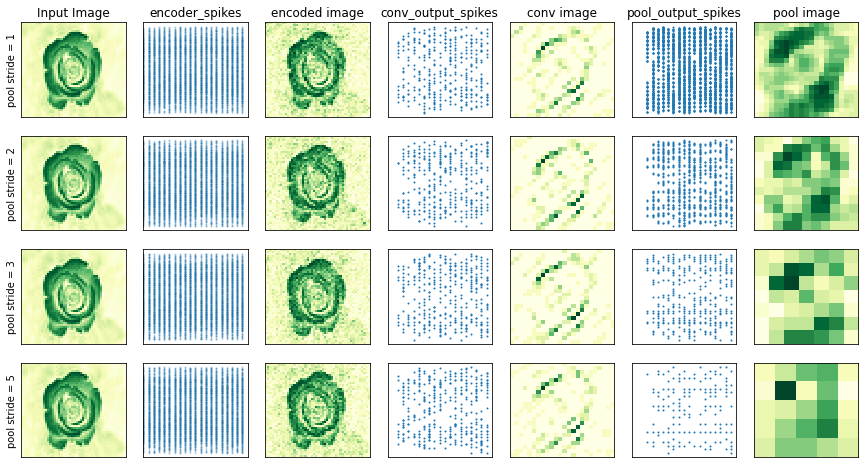

In [11]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    stride = [1,2,3,5][i]
    simulate(p, pooling_layer=CoreCentricFilter(core=torch.nn.MaxPool2d(
                kernel_size=4, stride=stride
    ), transform=norm), postfix=str(i), title=i==0, name=f'pool stride = {stride}')
p.show()

<div dir='rtl'>
مشاهده می‌کنیم که با stride هم اندازه با اندازه‌ی کرنل pooling (۳)،
پیکسل‌های خروجی حالت گسسته از هم پیدا می‌کنند اما می‌توان گفت که کل تصویر را پوشش می‌دهند. این امر منطقی است چرا که با اندازه‌ی stride = kernel_size، درواقع هر پیکسل ورودی pooling در یک و تنها یک پنجره از لایه‌ی pooling قرار می‌گیرد.
    <br/>
    همچنین مشاهده می‌کنیم که با stride های کوچکتر، رزولوشن افزایش پیدا کرده و می‌توان مشاهده کرد که پیکسل‌ها نسبت به ورودی کمی همپوشانی دارند. همچنین تعداد زیاد‌تر پیکسل‌های خروجی نیز مشاهده می‌شود که مورد انتظار است.
    <br/>
    در ردیف آخر نیز مشاهده می‌کنیم که با اندازه stride بزرگ‌تر از اندازه کرنل، با از دست دادن شدید اطلاعات روبرو هستیم. این امر نیز مورد انتظار است چرا که در این صورت، پیکسل‌هایی از تصویر ورودی لایه‌ی padding در هیچ پنجره‌ای قرار نمی‌گیرند و دیده نمی‌شوند.
</div>

<a id='7'></a>
<div dir='rtl'>
<h2>7. اثر padding لایه‌ی pooling</h2>
</div>

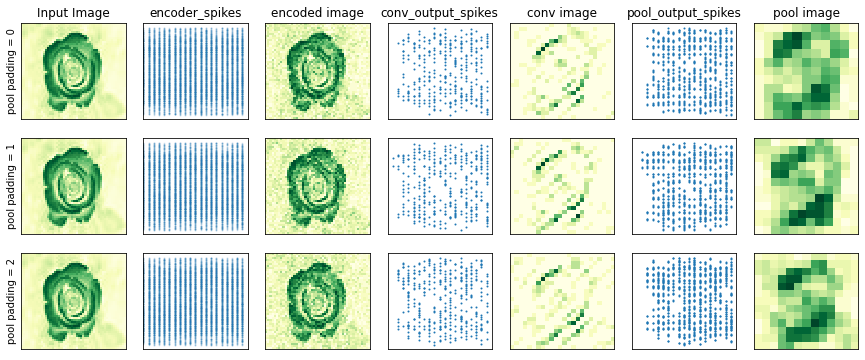

In [12]:
i_max = 3
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    simulate(p, pooling_layer=CoreCentricFilter(core=torch.nn.MaxPool2d(
                kernel_size=4, stride=2, padding=i
    ), transform=norm), postfix=str(i), title=i==0, name=f'pool padding = {i}')
p.show()

<div dir='rtl'>
توجه شود که در آزمایش بالا ناچار شدیم از kernel_size برابر ۴ استفاده کنیم تا بتوانیم padding برابر ۲ را نیز مشاهده کنیم. اثر padding برای لایه‌ی pooling نیز کاملا شبیه همین اثر برای لایه‌ی کانولوشن است. شما را به توضیحات آن بخش ارجاع می‌دهم.
</div>

<a id='8'></a>
<div dir='rtl'>
<h2>8. تفاوت max pooing و avg pooling</h2>
</div>

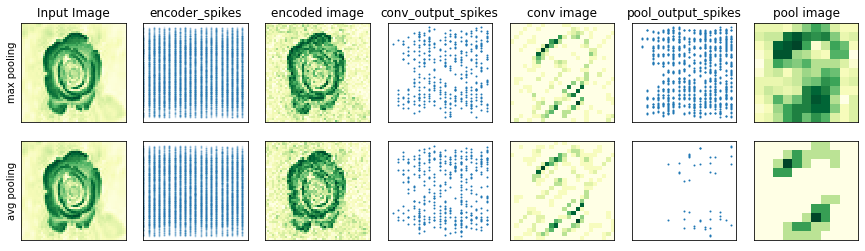

In [13]:
i_max = 2
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
simulate(p, pooling_layer=CoreCentricFilter(core=torch.nn.MaxPool2d(kernel_size=4, stride=2), transform=norm),
         postfix=str(0), title=True, name=f'max pooling')
simulate(p, pooling_layer=CoreCentricFilter(core=torch.nn.AvgPool2d(kernel_size=4, stride=2), transform=norm),
         postfix=str(1), title=False, name=f'avg pooling')
p.show()

<div dir='rtl'>
پیش‌تر درمورد max pooling گفته شد
که باعث می‌شود با کاهش کیفیت تصویر، درصد فعالیت نورون‌های متناظر با تصویر زیاد‌تر شده و در نتیجه نقاط رنگی‌تری در تصویر داشته باشیم. این مسئله در آزمایش بالا به خوبی دیده می‌شود. در تصویر پایین فعالیت کمتری دیده می‌شود که دلیل آن میانگین گیری فعالیت‌های ورودی است. با این حال می‌توان مشاهده کرد که هر دو نوع لایه، نمایش خوبی از ورودی خود ارائه می‌دهند و بسته به کاربرد، هر کدام می‌توانند مفید باشند.
</div>

<a id='9'></a>
<div dir='rtl'>
<h2>9. تفاوت نتایج برای روش‌های رمزنگاری Poisson و Time2FirstSpike</h2>
</div>

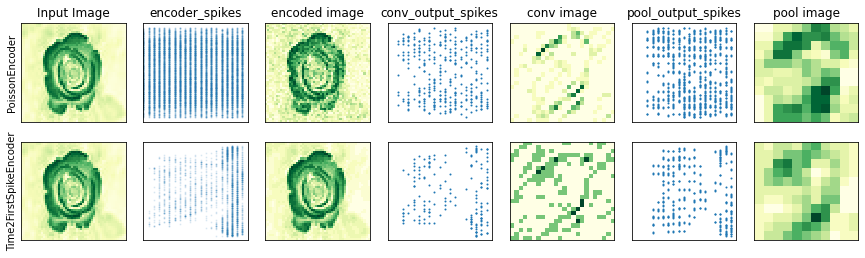

In [20]:
from cnsproject.network.encoders import PoissonEncoder,Time2FirstSpikeEncoder

i_max = 2
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
simulate(p, encoder=PoissonEncoder, postfix=str(0), title=True, name=f'PoissonEncoder')
simulate(p, encoder=Time2FirstSpikeEncoder, postfix=str(1), title=False, name=f'Time2FirstSpikeEncoder',
        axon_scale=1200)
p.show()

<div dir='rtl'>
ابتدا ذکر شود که در آزمایش بالا، اسکیل اثر اسپایک‌های ورودی لایه‌ی کانولوشن برای رمزنگاری Time to first spike را بیشتر از دو برابر دیگر آزمایش‌ها قرار دادیم.
    دلیل این کار آن است که فرکانس اسپایک زنی کدگذاری time to first spike بسیار کمتر از فرکانس کدگذاری پواسون است و این امر باعث می‌شود با پارامتر‌های یکسان، لایه‌ی کانولوشن مربوط به کدگذار time to first spike فعالیت بسیار ضعیفی داشته باشد و با اعمال pooling اثر محسوسی از فعالیت باقی نماند.
    با اعمال این ضریب، در جبران این ضعف کمک کردیم. با اینحال، با توجه به دلایل مطرح شده، امکان مقایسه‌ی دو آزمایش را از بعد فرکانس نداریم.
    <br/>
    مشاهده می‌شود که خروجی نهایی مدلی که از کدگذاری time to first spike استفاده می‌کند نیز نزدیک به مدلی است که از پواسون استفاده می‌کند. این مسئله شایان توجه است. کانولوشن در لحظات مختلفی اعمال می‌شود و شاید خطوطی که باید تشخیص دهد در لحظات مختلف تقسیم شوند و هیچگاه فیلتر مربوطه نتواند آن خطوط را تشخیص دهد. اما خبر مثبت آنجاییست که در لحظات مختلف، با اعمال فیلتر مربوطه، انباشت اختلاف پتانسیل در نورون‌های پس از لایه‌ی کانولوشن رخ داده و با این انباشت، خطوط در طول زمان تشخیص داده می‌شوند و در نتیجه، مدل قادر به تشخیص خطوط خواهد بود.
    با اینحال دقت کمتری نسبت به کد گذاری پواسون دارد چرا که کد گذاری پواسون، تشخیص خطوط را به امید لحظات آینده به تعویق نمی‌اندازد و مطمئن‌تر است. حال آنکه اگر زمان شبیه‌سازی کمتر باشد، مدل کدگذار time to first spike رفتار بهتری  خواهد داشت. چرا که انباشت سریع‌تر رخ می‌دهد و مدل عملکرد دقیق‌تری دارد. از طرفی کدگذار پواسون تصادفی عمل میکند و با کم بودن فرصت‌ها، بسیار ضعیف می‌شود.
</div>

<a id='10'></a>
<div dir='rtl'>
<h2>10. بررسی توابع convolution و pooling دستی پیاده سازی شده</h2>
</div>

<div dir='rtl'>
در این فاز خواسته شده بود که دو تابع کانولوشن و پولینگ توسط خود دانشجویان پیاده‌سازی شوند. همانطور که در ابتدای گزارش ذکر شد، این توابع به صورت کامل و دقیق پیاده سازی شده و در فایل utils.py قرار دارند اما به دلیل تمایل به حفظ ساختار پایتورچ محور کد، از استفاده آن در طول آزمایش خودداری شد (توجه شود که از این توابع در فاز قبل داخل شبکه استفاده شده و همسازی این دو نیز نشان داده شده است). در این قسمت درستی عملکرد این توابع را نشان خواهیم داد:
</div>

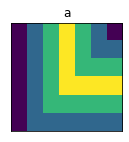

In [14]:
a = torch.tensor([
    [0,1,2,3,2,1,0],
    [0,1,2,3,2,1,1],
    [0,1,2,3,2,2,2],
    [0,1,2,3,3,3,3],
    [0,1,2,2,2,2,2],
    [0,1,1,1,1,1,1],
])
plt.figure(figsize=(2,2))
p = Plotter([
    ['a'],
])
p.imshow('a', a, title='a')

convolution test:


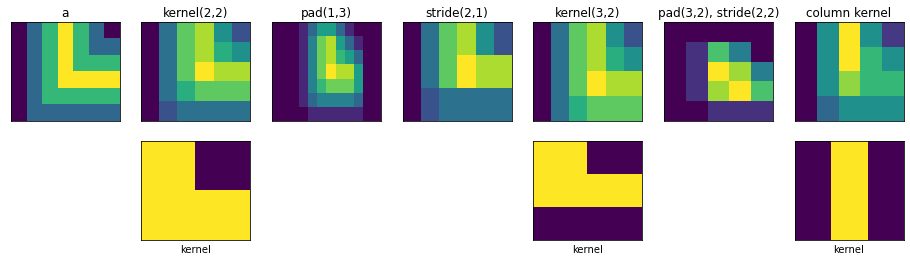

In [20]:
from cnsproject.utils import convolution2d

plt.figure(figsize=(16,4))
p = Plotter([
    ['a','b','c','d','e','f','g'],
    [None,'kb',None,None,'ke',None,'kg'],
])
print("convolution test:")
p.imshow('a', a, title='a')
kernel = torch.tensor([
    [2,0],
    [2,2]
])
p.imshow('b', convolution2d(a, kernel=kernel), title='kernel(2,2)')
p.imshow('kb', kernel, x_label='kernel')
p.imshow('c', convolution2d(a, kernel=kernel, padding=(1,3)), title='pad(1,3)')
p.imshow('d', convolution2d(a, kernel=kernel, stride=(2,1)), title='stride(2,1)')
kernel = torch.tensor([
    [2,0],
    [2,2],
    [0,0]
])
p.imshow('e', convolution2d(a, kernel=kernel), title='kernel(3,2)')
p.imshow('ke', kernel, x_label='kernel')
p.imshow('f', convolution2d(a, kernel=kernel, padding=(3,2), stride=2), title='pad(3,2), stride(2,2)')
kernel = torch.tensor([
    [0,2,0],
    [0,2,0],
    [0,2,0],
])
p.imshow('g', convolution2d(a, kernel=kernel), title='column kernel')
p.imshow('kg', kernel, x_label='kernel')

pooling test:
AvgPool info: kernel_size=3 and padding=3


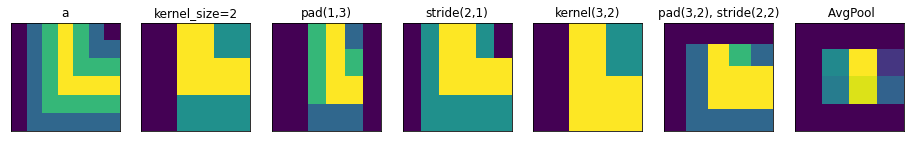

In [28]:
from cnsproject.utils import pooling2d

plt.figure(figsize=(16,2))
p = Plotter([
    ['a','b','c','d','e','f','g'],
])
print("pooling test:")
p.imshow('a', a, title='a')
p.imshow('b', pooling2d(a, kernel_size=2), title='kernel_size=2')
p.imshow('c', pooling2d(a, kernel_size=2, padding=(1,3)), title='pad(1,3)')
p.imshow('d', pooling2d(a, kernel_size=2, stride=(2,1)), title='stride(2,1)')
p.imshow('e', pooling2d(a, kernel_size=(3,2)), title='kernel(3,2)')
p.imshow('f', pooling2d(a, kernel_size=(3,2), padding=(3,2), stride=2), title='pad(3,2), stride(2,2)')
p.imshow('g', pooling2d(a, kernel_size=3, padding=3, aggregation=torch.mean), title=' AvgPool')
print('AvgPool info: kernel_size=3 and padding=3')

<div dir='rtl'>
همانطور که مشاهده می‌کنید، تمام پارامتر‌ها قابل تغییر بوده و به درستی کار می‌کنند. از کد‌های نوشته شده نیز می‌توانید مشاهده کنید که رابط کاربری صحیحی وجود دارد.
</div>